In [1]:
from common import utils, data, models, argbind, viz
import nussl
import torch
import os
from contextlib import contextmanager
import matplotlib.pyplot as plt
import numpy as np

argbind.ARGS['args.debug'] = True
utils.logger(level='info')

LABELS = ['bass', 'drums', 'other', 'vocals']

@contextmanager
def scope(args_path, override_args={}):
    with utils.chdir('../../..'):
        args = argbind.load_args(args_path)
        for key, val in override_args.items():
            args[key] = val
        with argbind.scope(args):
            yield args

logger <- level=info


10/01/2020 01:31:57 AM | utils.py:25 Switched working directory to ../../..


device <- use=cpu
deep_mask_estimation <- model_path=checkpoints/latest.model.pth, mask_type=soft
signal <- window_length=512, hop_length=128, window_type=sqrt_hann, sample_rate=16000
test/transform <- mask_type=msa, audio_only=False
test/mixer <- num_mixtures=10, duration=5.0, sample_rate=16000, ref_db=[-30, -10], n_channels=1, master_label=vocals, source_file=['choose', []], snr=['uniform', -10, 10], target_instrument=vocals, target_snr_boost=5.0, pitch_shift=['uniform', -2, 2], time_stretch=['uniform', 0.9, 1.1], coherent_prob=0.25, augment_prob=0.5, quick_pitch_time_prob=1.0, overfit_seed=0


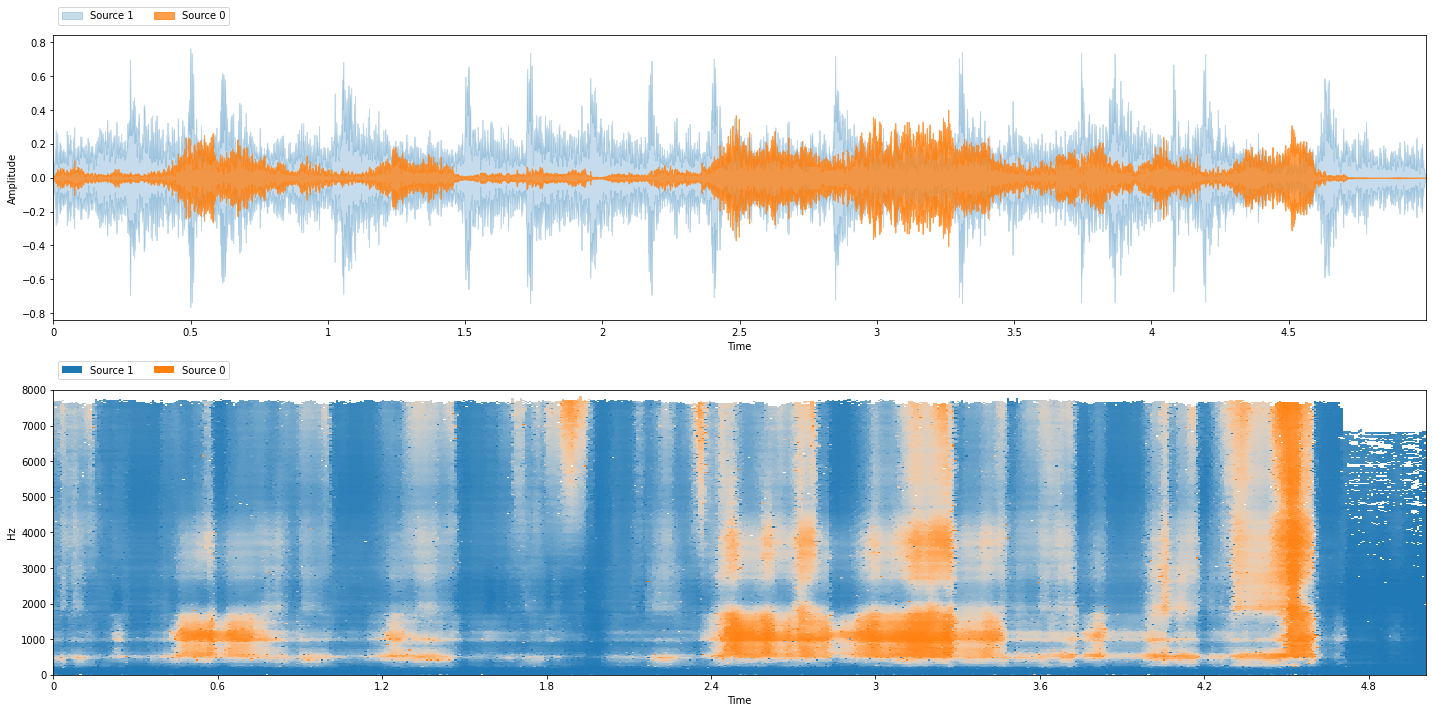


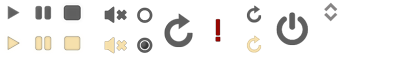
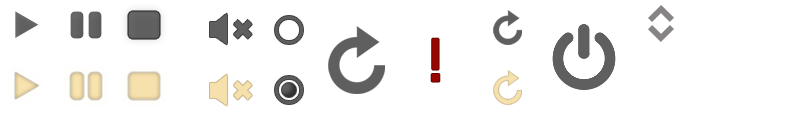
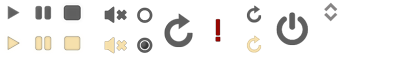

10/01/2020 01:32:02 AM | utils.py:29 Returning to /home/prem/research/tutorial/common/exp/notebooks


In [40]:
overrides = {
    'args.debug': True,
    'device.use': 'cpu',
    'deep_mask_estimation.model_path': 'checkpoints/latest.model.pth',
    'train/mixer.duration': 7.0,
}

with scope('common/exp/conf/chimera.yml', overrides) as args:    
    device = utils.device()
    separator = models.deep_mask_estimation(device)
    stft_params, sample_rate = data.signal()
    
    with argbind.scope(args, 'test'):
        tfm, new_labels = data.transform(stft_params, sample_rate, 'vocals', True)
        dataset = data.mixer(stft_params, tfm)
        
    item = dataset[np.random.randint(len(dataset))]
    
    separator.audio_signal = item['mix']
    estimates = separator()
    estimates.append(item['mix'] - estimates[0])
    
    viz.embed(estimates)